In [1608]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
import calendar 

import warnings

In [1609]:
import src.utils.preprocessing as pre

In [1610]:
data = pre.import_RFA()

print(data.shape)
data.head(5)

(198275, 7)


,SRC,TGT,VOT,RES,YEA,DAT,TXT
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",Support as conom.
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",Support as nominator.
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",Support per noms.
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",Support per noms. BDD is a strong contributor ...
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","Support, with great pleasure. I work with BDD ..."


# Pre-processing

## Converting Units or Types

In [1611]:
#Two different Formats identified in the DAT column with typos
#Error handling code from Stacksoverflow: "validate for multiple date / datetime formats" by 'c8999c 3f964f64'
def validate_datetime(string, whitelist=('%H:%M, %d %B %Y', '%H:%M, %d %b %Y')):
    for fmt in whitelist:
        try:
            dt = datetime.strptime(string, fmt)
        except ValueError:
            pass
        else: # if a defined format is found, datetime object will be returned
            return dt
    else: # all formats done, none did work...
        return False # could also raise an exception here

def dates_prep(data):
    data['YEA'] = data['YEA'].astype(int)
    dates =[]
    for t in data['DAT']:
        dates.append(validate_datetime(t))

    dates = pd.DataFrame(dates)
    dates[dates[0]==False] = dates[dates[0]==False].replace(to_replace=False, value = float('NaN'))

    datetime_object_date = dates.apply(lambda x: x[0].date() if type(x[0])!=float else x[0], axis=1)
    datetime_object_month= dates.apply(lambda x: calendar.month_name[x[0].month] if type(x[0])!=float else x[0], axis=1)
    datetime_object_time = dates.apply(lambda x: x[0].time() if type(x[0])!=float else x[0], axis=1)

    # Converting types of DAT and adding TIM column
    data['DAT'] = datetime_object_date
    data['MON'] = datetime_object_month
    data['TIM'] = datetime_object_time
    # Reordering columns
    data = data.iloc[:,[0,1,2,3,4,5,7,8,6]]

    return data

In [1612]:
dates_prep(data)

C:\Users\mikai\AppData\Local\Temp\ipykernel_27020\3965000785.py:21: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,SRC,TGT,VOT,RES,YEA,DAT,MON,TIM,TXT
0,Steel1943,BDD,1,1,2013,2013-04-19,April,23:13:00,Support as conom.
1,Cuchullain,BDD,1,1,2013,2013-04-20,April,01:04:00,Support as nominator.
2,INeverCry,BDD,1,1,2013,2013-04-19,April,23:43:00,Support per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20,April,00:11:00,Support per noms. BDD is a strong contributor ...
4,Miniapolis,BDD,1,1,2013,2013-04-20,April,00:56:00,"Support, with great pleasure. I work with BDD ..."
...,...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,2003-09-02,September,02:51:00,Support
198271,Angela,WhisperToMe,1,1,2003,2003-11-26,November,23:45:00,Support.
198272,Jiang,WhisperToMe,1,1,2003,NaN,NaN,NaN,Support.
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05,December,05:38:00,Support. Age has nothing to do with maturity.


In [1613]:
#Error handling 
#data.iloc[6821,5]   = '14:47, 1 July 2012'
#data.iloc[8264,5]   = '19:19, 11 June 2012'
#data.iloc[27608,5]  = '20:44, 3 January 2010'
#data.iloc[46102,5]  = '02:41, 29 October 2009'
#data.iloc[70591,5]  = '21:29, 24 May 2008' #arbitrarily setting hour to fix error
#data.iloc[90613,5]  = '17:33, 24 January 2004'
#data.iloc[90619,5]  = '13:06, 25 January 2004'
#data.iloc[116963,5] = '17:44, 26 May 2007'
#data.iloc[117480,5] = '05:17, 29 March 2004'

(array([ 161.,  139.,  240.,  308.,  323.,  297.,  567.,  844., 1674.,
        4818.]),
 array([   707. ,  20463.7,  40220.4,  59977.1,  79733.8,  99490.5,
        119247.2, 139003.9, 158760.6, 178517.3, 198274. ]),
 <BarContainer object of 10 artists>)

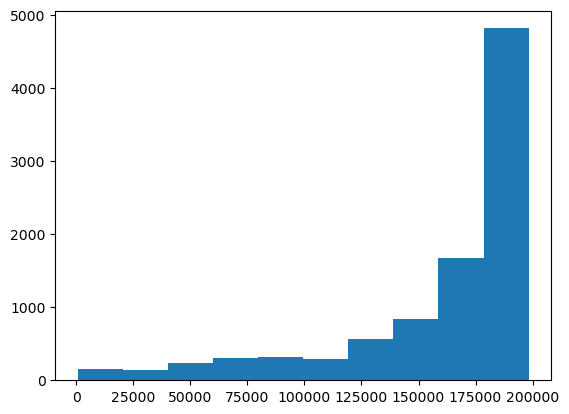

In [1614]:
plt.hist(dates[dates[0].isnull()==True].index)

We won't interpolate data for the moment, because in the case of the very first elections (2003-2004), we would be interpolating too many values which would not give an accurate timeline of votes

## Identifying Unique Elections Candidates & Elections

In [1615]:
data['TGT'].value_counts()

TGT
Everyking         987
TenPoundHammer    778
MZMcBride         663
Cobi              639
Elonka            628
                 ... 
downtowndontay      1
Jdforrester         1
Etan                1
jstupple7           1
Zanimum             1
Name: count, Length: 3497, dtype: int64

In [1616]:
data

,SRC,TGT,VOT,RES,YEA,DAT,TXT,MON,TIM
0,Steel1943,BDD,1,1,2013,2013-04-19,Support as conom.,April,23:13:00
1,Cuchullain,BDD,1,1,2013,2013-04-20,Support as nominator.,April,01:04:00
2,INeverCry,BDD,1,1,2013,2013-04-19,Support per noms.,April,23:43:00
3,Cncmaster,BDD,1,1,2013,2013-04-20,Support per noms. BDD is a strong contributor ...,April,00:11:00
4,Miniapolis,BDD,1,1,2013,2013-04-20,"Support, with great pleasure. I work with BDD ...",April,00:56:00
...,...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,2003-09-02,Support,September,02:51:00
198271,Angela,WhisperToMe,1,1,2003,2003-11-26,Support.,November,23:45:00
198272,Jiang,WhisperToMe,1,1,2003,NaN,Support.,NaN,NaN
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05,Support. Age has nothing to do with maturity.,December,05:38:00


In [1617]:
x= data.groupby(['TGT','RES'])[['TGT','YEA']].value_counts()

In [1618]:
#for row in range(1,len(data),1):
#    if type(data.iloc[row,5]) == float:
#        data.iloc[row,5]= data.iloc[row-1,5]
#        print('updated Election', data.iloc[row,9], 'row:', row)
#    elif data.iloc[row,9] == data.iloc[row-1,9] or \
#       data[data['elec_id']==data.iloc[row,9]]['DAT'][row].month == data[data['elec_id']==data.iloc[row,9]]['DAT'][row].month+1 or \
#        data[data['elec_id']==data.iloc[row,9]]['DAT'][row].month == data.iloc[row,5].month-1:
#        print('Same Election', data.iloc[row,9], 'row:', row)
#    else:
#        print('elec_id:',data.iloc[row,9], 'row:', row)

In [1619]:
#for row in range(0,len(data),1):
#    if type(data.iloc[row,5]) == float:
#        data.iloc[row,5]= data.iloc[row-1,5]
#        print('updated Election', data.iloc[row,9], 'row:', row)
#    elif data[data['elec_id']==data.iloc[row,9]]['DAT'][row].month == data[data['elec_id']==data.iloc[row-1,9]]['DAT'][row-1].month or \
#        data[data['elec_id']==data.iloc[row,9]]['DAT'][row].month == data[data['elec_id']==data.iloc[row,9]]['DAT'][row].month+1 or \
#        data[data['elec_id']==data.iloc[row,9]]['DAT'][row].month == data.iloc[row,5].month-1:
#        print('Same Election', data.iloc[row,9], 'row:', row)
#    else:
#        print('elec_id:',data.iloc[row,9], 'row:', row)

In [1620]:
data[data.duplicated(subset=['TGT','YEA','MON'], keep=False)][['TGT','MON','YEA']].groupby(['TGT']).value_counts()

TGT                      MON        YEA 
(aeropagitica)           March      2006     31
                         February   2006     20
07bargem                 September  2010      6
1234r00t                 May        2010      6
168...                   December   2003      5
                                           ... 
zhudyzhu                 June       2006      2
Ævar Arnfjörð Bjarmason  October    2005     68
                         May        2004     14
Σ                        October    2012    217
Ђорђе Д. Божовић         November   2005     18
Name: count, Length: 4495, dtype: int64

In [1621]:
data[data.duplicated(subset=['TGT','YEA'], keep=False)][['TGT','YEA']].groupby(['TGT']).value_counts().head(10)

TGT             YEA 
(aeropagitica)  2006     55
07bargem        2010      6
1234r00t        2010      6
168...          2003      7
21655           2008     24
23skidoo        2005     58
28bytes         2011    130
                2010     58
2over0          2009     94
4836.03         2006     26
Name: count, dtype: int64

In [1622]:
data.drop_duplicates(subset=['TGT','YEA'])[['TGT','YEA']].groupby(['TGT']).value_counts().head(10)

TGT             YEA 
(aeropagitica)  2006    1
07bargem        2010    1
1234r00t        2010    1
168...          2003    1
21655           2008    1
23skidoo        2005    1
28bytes         2010    1
                2011    1
2over0          2009    1
4836.03         2006    1
Name: count, dtype: int64

In [1623]:
x= data.drop_duplicates(subset=['TGT','YEA'])[['TGT','YEA']].groupby(['TGT']).value_counts().reset_index()
x[x.duplicated(subset=['TGT'],keep=False)].value_counts()

TGT                      YEA   count
28bytes                  2010  1        1
RadioFan                 2009  1        1
RadioKirk                2005  1        1
                         2006  1        1
Rami R                   2010  1        1
                                       ..
HJ Mitchell              2011  1        1
Haham hanuka             2005  1        1
                         2006  1        1
Hahc21                   2012  1        1
Ævar Arnfjörð Bjarmason  2005  1        1
Name: count, Length: 604, dtype: int64

In [1624]:
#Can tell elections apart from different results
data[data['TGT']=='28bytes']


,SRC,TGT,VOT,RES,YEA,DAT,TXT,MON,TIM
10046,Pedro,28bytes,1,1,2011,2011-06-07,"As conominator. <small><span style=""border:1px...",June,14:35:00
10047,Steven Zhang,28bytes,1,1,2011,2011-06-07,"Pedro lays out the facts well, and I largely a...",June,14:37:00
10048,TBloemink,28bytes,1,1,2011,2011-06-07,"Support no problems here, success!",June,14:37:00
10049,Worm That Turned,28bytes,1,1,2011,2011-06-07,Support Certainly.,June,14:48:00
10050,SoWhy,28bytes,1,1,2011,2011-06-07,{{ec}} Support Per last time. Regards,June,14:50:00
...,...,...,...,...,...,...,...,...,...
27350,Chrism,28bytes,-1,-1,2010,2010-12-03,"Reluctant oppose As per Sven Manguard et al.,...",December,00:40:00
27351,Reyk,28bytes,0,-1,2010,2010-12-01,Neutral I can see by your answers to the quest...,December,22:57:00
27352,Ajbpearce,28bytes,0,-1,2010,2010-12-01,Neutral Your edits and answers show that you a...,December,23:09:00
27353,OlEnglish,28bytes,0,-1,2010,2010-12-02,Neutral. Still undecided.,December,07:22:00


In [1625]:
#can tell elections apart from being more than one year apart (non-consecutive)
data[data['TGT']=='RadioFan']


,SRC,TGT,VOT,RES,YEA,DAT,TXT,MON,TIM
17837,Baseball Watcher,RadioFan,1,-1,2011,2011-03-06,Support Dont see anything wrong with candidate...,March,23:35:00
17838,Strikerforce,RadioFan,1,-1,2011,2011-03-06,Support as nominator.,March,23:36:00
17839,Gabriele449,RadioFan,1,-1,2011,2011-03-07,Support Great candidate.,March,00:08:00
17840,Dank,RadioFan,1,-1,2011,2011-03-07,"Ive noticed his work for years. Dedicated, co...",March,01:19:00
17841,BuickCenturyDriver,RadioFan,1,-1,2011,2011-03-07,Looks good enough to me. &ndash;,March,01:26:00
17842,Shadowjams,RadioFan,1,-1,2011,2011-03-07,Strong Support <strike>just to counteract</st...,March,11:35:00
17843,Fetchcomms,RadioFan,-1,-1,2011,2011-03-07,The answer to Q4 doesnt answer anything. Unles...,March,04:21:00
17844,Swarm,RadioFan,-1,-1,2011,2011-03-07,{{ec}} Oppose. Concerns about judgment. In Feb...,March,04:35:00
17845,Courcelles,RadioFan,-1,-1,2011,2011-03-07,Oppose I dont think you really understand dele...,March,05:22:00
17846,Neutralhomer,RadioFan,-1,-1,2011,2011-03-07,Oppose: Per Swarm and Courcelles above and 28B...,March,06:52:00


In [1626]:
data[data['TGT']=='RadioKirk'].tail(50)


,SRC,TGT,VOT,RES,YEA,DAT,TXT,MON,TIM
145727,Thunderbrand,RadioKirk,1,1,2006,2006-04-30,Support.,April,16:15:00
145728,Davewild,RadioKirk,1,1,2006,2006-04-30,Support No reason why should not be.,April,16:47:00
145729,Mackensen,RadioKirk,1,1,2006,2006-04-30,Support. His statesmanlike handling of the [[U...,April,18:14:00
145730,Buchanan-Hermit,RadioKirk,1,1,2006,2006-04-30,Support. This dude kicks a$$. :D [[User:Buchan...,April,18:37:00
145731,Kukini,RadioKirk,1,1,2006,2006-04-30,Support,April,21:43:00
145732,Jahiegel,RadioKirk,1,1,2006,2006-05-01,"Support, of course, per Reyk, Davewild, Tantal...",May,03:05:00
145733,Arnzy,RadioKirk,1,1,2006,2006-05-01,Support per all other reasons.,May,03:12:00
145734,Metamagician3000,RadioKirk,1,1,2006,2006-05-01,Support solid editor.,May,05:10:00
145735,Irpen,RadioKirk,1,1,2006,2006-05-01,Support.,May,05:28:00
145736,Kingboyk,RadioKirk,1,1,2006,2006-05-01,Support. Seems to be acting like an admin alre...,May,07:33:00


In [1627]:
data[data['TGT']=='Rami R']


,SRC,TGT,VOT,RES,YEA,DAT,TXT,MON,TIM
13852,Pedro,Rami R,1,1,2011,2011-02-07,Support Per [[User_talk:Rami_R/Archive_2#Your_...,February,11:50:00
13853,Frank,Rami R,1,1,2011,2011-02-07,"Support (again). <small><span style=""padding:2...",February,12:31:00
13854,Boing! said Zebedee,Rami R,1,1,2011,2011-02-07,"Support. Last time I said things like ""Ive loo...",February,13:58:00
13855,Ajraddatz,Rami R,1,1,2011,2011-02-07,Support No reason why not; a wellbalanced edi...,February,14:40:00
13856,GlassCobra,Rami R,1,1,2011,2011-02-07,"Support, just as last time.",February,17:41:00
...,...,...,...,...,...,...,...,...,...
30889,Ottawa4ever,Rami R,0,-1,2010,2010-03-03,Neutral I have no reason to oppose. I am thoug...,March,10:25:00
30890,RP459,Rami R,0,-1,2010,2010-03-04,"Neutral User has a clue, but I dont feel they...",March,02:05:00
30891,RL0919,Rami R,0,-1,2010,2010-03-07,"Neutral. Like the neutrals above, I dont see a...",March,02:44:00
30892,Coffee,Rami R,0,-1,2010,2010-03-08,[[User:Coffee/RFAstandards|Neutral]] Rami see...,March,07:35:00


In [1628]:
data[data['DAT']==dt.datetime(2006,12,31).date()]

,SRC,TGT,VOT,RES,YEA,DAT,TXT,MON,TIM
105703,Jorcoga,Savidan,1,1,2007,2006-12-31,Support per all of the above.,December,00:43:00
105705,Shyam Bihari,Savidan,1,1,2007,2006-12-31,Support an experienced user.,December,05:29:00
105706,Tewfik,Savidan,1,1,2007,2006-12-31,"Support qualified candidate, <font style=""colo...",December,18:24:00
105707,Carioca,Savidan,1,1,2007,2006-12-31,Support. Good editor.,December,20:15:00
105708,Canadian-Bacon,Savidan,1,1,2007,2006-12-31,"Support A good candidate, will make an excelle...",December,22:28:00
112406,Jorcoga,BostonMA,1,-1,2007,2006-12-31,Support Im not convinced he wouldnt make a goo...,December,00:51:00
112407,Siva1979,BostonMA,1,-1,2007,2006-12-31,Support It is time to give him the mop. <font ...,December,01:21:00
112408,SandyDancer,BostonMA,1,-1,2007,2006-12-31,Support I have noticed him around but had no d...,December,01:24:00
112409,Jossi,BostonMA,1,-1,2007,2006-12-31,"Support. A knowledgeable, sensible and wellrou...",December,01:29:00
112410,Aksi great,BostonMA,1,-1,2007,2006-12-31,Strong support I would have been one of the f...,December,15:30:00


In [1629]:
data[data['TGT']=='BostonMA']

,SRC,TGT,VOT,RES,YEA,DAT,TXT,MON,TIM
112343,Paul Pigman,BostonMA,1,-1,2007,2006-12-26,Strong Support Fairminded and levelheaded in t...,December,22:03:00
112344,Kathryn NicDhàna,BostonMA,1,-1,2007,2006-12-26,Strong Support I first met BostonMA when he sh...,December,22:11:00
112345,Deepujoseph,BostonMA,1,-1,2007,2006-12-27,Strong Support All my interactions with him h...,December,06:40:00
112346,HighInBC,BostonMA,1,-1,2007,2006-12-27,Support This editor can hold an opposing point...,December,07:40:00
112347,Shreshth91,BostonMA,1,-1,2007,2006-12-27,"Approved. <span class=""usersig userShreshth91""...",December,09:41:00
...,...,...,...,...,...,...,...,...,...
112471,Lethaniol,BostonMA,0,-1,2007,2006-12-29,Neutral per the concerns raised in the Oppose ...,December,14:46:00
112472,Herbythyme,BostonMA,0,-1,2007,2006-12-30,Neutral obviously a useful editor but equally...,December,10:53:00
112473,Utcursch,BostonMA,0,-1,2007,2006-12-31,"Neutral. Great editor, but very recent speedyt...",December,09:41:00
112474,Insanephantom,BostonMA,0,-1,2007,2007-01-01,Neutral Close to support as a good contributo...,January,13:23:00


In [1630]:
data[data['DAT']==dt.datetime(2013,1,1).date()][['TGT','YEA','DAT']].value_counts()

TGT       YEA   DAT       
Ocaasi    2013  2013-01-01    19
Darkwind  2013  2013-01-01    12
Name: count, dtype: int64

In [1631]:
#Only problematic one when looking at new years dates, some are labelled as 2008 when the corresponding post date is 2007
data[data['TGT']=='Floaterfluss']

,SRC,TGT,VOT,RES,YEA,DAT,TXT,MON,TIM
75248,Majorly,Floaterfluss,1,-1,2008,2007-01-01,"Moral support You seem like a good editor, but...",January,19:11:00
75249,Nishkid64,Floaterfluss,-1,-1,2008,2007-01-01,Oppose. I appreciate your dedication to the pr...,January,18:39:00
75250,TeckWiz,Floaterfluss,-1,-1,2008,2007-01-01,(edit conflict)OpposeYouve only been here for ...,January,18:42:00
75251,PrestonH,Floaterfluss,-1,-1,2008,2007-01-01,"Oppose You only have 600 edits, and you appear...",January,18:46:00
75252,^demon,Floaterfluss,-1,-1,2008,2007-01-01,"Weak Oppose. Im not one to count edits, but yo...",January,18:59:00
75253,TSO1D,Floaterfluss,-1,-1,2008,2007-01-01,"Oppose Im sorry, but you just need more experi...",January,19:28:00
75254,Arjun01,Floaterfluss,-1,-1,2008,2007-01-01,Oppose per above and Q1 did not leave me inspi...,January,19:44:00
75255,Anas Salloum,Floaterfluss,-1,-1,2008,2007-01-01,"Oppose Sorry, too early. Work on the advice yo...",January,19:50:00
115555,Majorly,Floaterfluss,1,-1,2007,2007-01-01,"Moral support You seem like a good editor, but...",January,19:11:00
115556,Nishkid64,Floaterfluss,-1,-1,2007,2007-01-01,Oppose. I appreciate your dedication to the pr...,January,18:39:00


After Manually scrolling through the borderline dates, I see that the borderline dates before the new year are labeled with a year of the following year if they have at least one comment in the following year. <strong>This leads me to believe that the documentation is incorrect and that the YEA is for the year that the election ended</strong>. 

All except one TGT in the borderline dates in the new year are properly documented. The one mistake is an accident and there seems to be a duplication of commments with some having the year 2008. Wrong ones were deleted.

In [1632]:
#Assumption n°1: Only one election by year
#Assumption n°2: If failed, canidate needs to wait a year before reapplying
#Assumption n°3(VIOLATED): +1 can only be attributed to the final year as it would be improbable that someone passes then has to run again 
#It is possible to adminship --> interesting avenue for data analysis


#Idea is to group the elections by TGT, YEA then RES



In [1633]:
#test to check if we have any values which exist more than once
(data.drop_duplicates(subset=['TGT','YEA','RES']).groupby('TGT').value_counts()>1).sum()

0

In [1634]:
data.drop_duplicates(subset=['TGT','YEA','RES']).value_counts().head(10)

SRC                     TGT            VOT  RES  YEA   DAT         TXT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      MON       TIM     
'sed                    Crisspy         1   -1   2006  2006-07-21  Support I think that Crisspy would make a good admin. Wikipedia is way too bureaucratic and Crisspy would stop that.                                                                                                                                                  

In [1635]:
def prep_unique_elections(data_original):
    unique_elections = data_original.drop_duplicates(subset=['TGT','YEA','RES']).groupby('TGT').value_counts(dropna=False).reset_index()
    unique_elections= unique_elections.drop('count', axis=1)

    unique_candidate_freq_table= pd.DataFrame(unique_elections['TGT'].value_counts())
    single_runners_list = unique_candidate_freq_table[unique_candidate_freq_table['count']==1].index
    multiple_runners_list = unique_candidate_freq_table[unique_candidate_freq_table['count']>1].index
    
    unique_candidate_freq_table = unique_candidate_freq_table.reset_index()

    return unique_elections

In [1636]:
prep_unique_elections(data)

,TGT,SRC,VOT,RES,YEA,DAT,TXT,MON,TIM
0,(aeropagitica),Dbiv,1,1,2006,2006-02-28,"Support. Yippee, I get to be the first!",February,00:09:00
1,07bargem,Salvio giuliano,-1,-1,2010,2010-09-29,"Oppose. Sorry to be the first one, but you onl...",September,19:42:00
2,1234r00t,Shirik,-1,-1,2010,2010-05-20,[[WP:NOTNOW|Not now]]. The fact that you menti...,May,00:06:00
3,168...,Cyp,1,1,2003,2003-11-30,Support 2³&times;3&times;7... [[User:Cyp|&#922...,November,23:12:00
4,21655,Glacier Wolf,1,-1,2008,2008-03-17,"Support as nominator. Good luck! <font face=""v...",March,22:08:00
...,...,...,...,...,...,...,...,...,...
3921,zhudyzhu,Kimchi.sg,-1,-1,2006,2006-06-13,Strong oppose 1. Failed to create RfA before ...,June,06:23:00
3922,Ævar Arnfjörð Bjarmason,Viajero,1,1,2004,2004-05-18,Seems coolheaded (would you expect otherwise f...,May,11:53:00
3923,Ævar Arnfjörð Bjarmason,WikiFanatic,1,-1,2005,NaN,"Support, obviously, as the nominator of Ævar.",NaN,NaN
3924,Σ,Legoktm,1,-1,2012,2012-10-02,"Support as conom. <span style=""border:1px soli...",October,01:42:00


In [1637]:
print("Candidates who only ran once:", (unique_elections['TGT'].value_counts()==1).sum(),
      "\nCandidates who ran multiple times:", (unique_elections['TGT'].value_counts(dropna=False)>1).sum(),
      "\nTotal unique candidates:",(unique_elections['TGT'].value_counts()<2).sum() +(unique_elections['TGT'].value_counts()>1).sum()) #unique candidates

if ((unique_elections['TGT'].value_counts()<2).sum() +(unique_elections['TGT'].value_counts()>1).sum()) == len(unique_elections['TGT'].value_counts()):
    print('No Data Points Lost')
else:
    print('datapoints lost')


Candidates who only ran once: 3111 
Candidates who ran multiple times: 386 
Total unique candidates: 3497
No Data Points Lost


In [1638]:
(unique_elections['TGT'].value_counts()<2).sum() +(unique_elections['TGT'].value_counts()>1).sum() #no loss of datapoints

3497

In [1639]:
unique_elections[unique_elections['TGT'].isin(multiple_runners_list)]

,TGT,SRC,VOT,RES,YEA,DAT,MON,TIM,TXT,elec_id
6,28bytes,Malinaccier,1,-1,2010,2010-12-01,December,18:35:00,"Support. At first, I was somewhat hesitant to...",7
7,28bytes,Pedro,1,1,2011,2011-06-07,June,14:35:00,"As conominator. <small><span style=""border:1px...",8
13,7,Bubba hotep,1,1,2010,2010-05-29,May,08:07:00,Strong support Absolutely thrilled to see this...,14
14,7,Law,1,-1,2009,2009-08-14,August,05:57:00,Support That was a long read.,15
18,9cds,Celardore,1,-1,2006,2006-06-08,June,23:23:00,Support Ive come into contact with this editor...,19
...,...,...,...,...,...,...,...,...,...,...
3816,^demon,^demon,1,-1,2005,2005-12-16,December,17:05:00,"<strike>I, of course, support myself in this s...",3817
3903,shoeofdeath,Politics rule,1,-1,2007,2007-09-09,September,01:14:00,"Support Good editor. Solid edit count, and goo...",3904
3904,shoeofdeath,Yanksox,1,1,2008,2008-02-29,February,00:23:00,Seems to fit the mold of what an old school ad...,3905
3922,Ævar Arnfjörð Bjarmason,Viajero,1,1,2004,2004-05-18,May,11:53:00,Seems coolheaded (would you expect otherwise f...,3923


In [1640]:
#Pass Rate ???
print('Pass Rate for single time Runners')
print(unique_elections[unique_elections['TGT'].isin(single_runners_list)]['RES'].value_counts(normalize=True))

print('\nPass Rate for multiple time Runners')
print(unique_elections[unique_elections['TGT'].isin(multiple_runners_list)]['RES'].value_counts(normalize=True))

Pass Rate for single time Runners
RES
 1    0.532626
-1    0.467374
Name: proportion, dtype: float64

Pass Rate for multiple time Runners
RES
-1    0.674847
 1    0.325153
Name: proportion, dtype: float64


### Everyking - Example of losing Adminship

In [1641]:
unique_elections[unique_elections['TGT']=='Everyking']

,TGT,SRC,VOT,RES,YEA,DAT,MON,TIM,TXT,elec_id
1094,Everyking,172,1,1,2004,2004-05-03,May,22:46:00,,1095
1095,Everyking,Antandrus,1,1,2010,2010-01-18,January,21:25:00,Support as nominator; with pleasure.,1096
1096,Everyking,Chacor,1,-1,2006,2006-09-10,September,04:19:00,Weak support per [[User:Chacor/RFA criteria|my...,1097
1097,Everyking,Durova,1,-1,2008,2008-08-25,August,19:24:00,"Support as conominator. <font face=""Verdana"">",1098
1098,Everyking,Friday,1,-1,2009,2009-05-08,May,16:32:00,This RFA has the huge advantage of no guessing...,1099
1099,Everyking,MatthewFenton,1,-1,2007,2007-02-07,February,13:11:00,Support — naturally as nominator. <span style=...,1100


<strong>Everyking is a clear example that it is possible to loose status as Admin</strong>

In [1642]:
unique_elections[unique_elections['TGT']=='Ktr101']

,TGT,SRC,VOT,RES,YEA,DAT,MON,TIM,TXT,elec_id
1901,Ktr101,Keegan,1,-1,2012,2012-12-22,December,08:21:00,Per nom and answers to questions.,1902
1902,Ktr101,Le Grand Roi des Citrouilles,1,-1,2008,2008-07-10,July,18:51:00,Support for same reason I gave last time. <fo...,1903
1903,Ktr101,Rlevse,1,-1,2010,2010-05-31,May,22:03:00,Strong support as nom. And of course recuse fr...,1904
1904,Ktr101,Tdrss,1,-1,2009,2009-07-30,July,02:19:00,Support wholeheartedly for adminship.,1905


In [1643]:
data[(data['TGT']=='Everyking') & (data['YEA']==2006)]

,SRC,TGT,VOT,RES,YEA,DAT,TXT,MON,TIM
158519,Chacor,Everyking,1,-1,2006,2006-09-10,Weak support per [[User:Chacor/RFA criteria|my...,September,04:19:00
158520,Kbdank71,Everyking,1,-1,2006,2006-09-10,Support. Reason for desysopping was quite wea...,September,04:22:00
158521,Alkivar,Everyking,1,-1,2006,2006-09-10,Weak Support. I dont think EK has ever really ...,September,04:37:00
158522,Thatdog,Everyking,1,-1,2006,2006-09-10,Support. I dont believe the overblown edit wa...,September,04:43:00
158523,gadfium,Everyking,1,-1,2006,2006-09-10,"Support. This shouldnt be necessary, as he sho...",September,04:56:00
158524,Mark,Everyking,1,-1,2006,2006-09-10,Support I am by no means a fan of Everykings ...,September,05:53:00
158525,Deathphoenix,Everyking,1,-1,2006,2006-09-10,"Support, I fully expect there to be a tonne of...",September,07:26:00
158526,Haukurth,Everyking,1,-1,2006,2006-09-10,"Support, per my nomination above.",September,08:04:00
158527,Merovingian,Everyking,1,-1,2006,2006-09-10,,September,08:26:00
158528,Mark Dingemanse,Everyking,1,-1,2006,2006-09-10,"Strong support. In my opinion, the desysopping...",September,10:25:00


# Things to do:

- Assign unique Election ID (using TGT, YEA, Result)
- Calculate the amount of votes per election
- lost adminship?

- repeat the above for users (voters)
    - voter id 
    - total times voted per election
    - total times votes
    - elected between 2003 and 2013
    - year elected?


### election id

In [ ]:
def prep_elec_id(unique_elections_data):
    unique_elections_data['elec_id']= np.linspace(1,len(unique_elections_data),len(unique_elections_data))
    unique_elections_data['elec_id']= unique_elections_data['elec_id'].astype(int)
    
    data['elec_id']= np.empty(198275)
    data['elec_id']= data['elec_id'].astype(int)

    for row in range(0,len(data['TGT']),1):
        data.iloc[row,9] = unique_elections[(unique_elections['TGT']==data.iloc[row,1]) & 
                                        (unique_elections['YEA']== data.iloc[row,4]) &
                                        (unique_elections['RES']== data.iloc[row,3])]['elec_id']
    #print(data.iloc[row,[0,1,9]], row) #To Troubleshoot and find row which is giving error

    win,loss =[],[]
    
    for row in range(0,len(unique_candidate_freq_table),1):
        if len(unique_elections[unique_elections['TGT']==unique_candidate_freq_table.iloc[row,0]][['TGT','RES']].value_counts().index) == 2:
            loss.append(unique_elections[unique_elections['TGT']==unique_candidate_freq_table.iloc[row,0]][['TGT','RES']].value_counts()[0])
            win.append(unique_elections[unique_elections['TGT']==unique_candidate_freq_table.iloc[row,0]][['TGT','RES']].value_counts()[1])
        elif len(unique_elections[unique_elections['TGT']==unique_candidate_freq_table.iloc[row,0]][['TGT','RES']].value_counts().index) ==1 and\
        unique_elections[unique_elections['TGT']==unique_candidate_freq_table.iloc[row,0]][['TGT','RES']].value_counts().index[0][1] == -1:
            loss.append(unique_elections[unique_elections['TGT']==unique_candidate_freq_table.iloc[row,0]][['TGT','RES']].value_counts()[0])
            win.append(0)
        elif len(unique_elections[unique_elections['TGT']==unique_candidate_freq_table.iloc[row,0]][['TGT','RES']].value_counts().index) ==1 and\
        unique_elections[unique_elections['TGT']==unique_candidate_freq_table.iloc[row,0]][['TGT','RES']].value_counts().index[0][1] == 1:
            loss.append(0)
            win.append(unique_elections[unique_elections['TGT']==unique_candidate_freq_table.iloc[row,0]][['TGT','RES']].value_counts()[0])
        else:
            print('Something unexpected happen')

    unique_candidate_freq_table['win'] = win
    unique_candidate_freq_table['loss'] = loss
    return unique_candidate_freq_table

In [1645]:
prep_elec_id(unique_elections)

C:\Users\mikai\AppData\Local\Temp\ipykernel_27020\2879456343.py:18: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\mikai\AppData\Local\Temp\ipykernel_27020\2879456343.py:19: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\mikai\AppData\Local\Temp\ipykernel_27020\2879456343.py:18: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\mikai\AppData\Local\Temp\ipykernel_27020\2879456343.py:19: FutureWarning:

Series.__g

In [1646]:
unique_elections

,TGT,SRC,VOT,RES,YEA,DAT,MON,TIM,TXT,elec_id
0,(aeropagitica),Dbiv,1,1,2006,2006-02-28,February,00:09:00,"Support. Yippee, I get to be the first!",1
1,07bargem,Salvio giuliano,-1,-1,2010,2010-09-29,September,19:42:00,"Oppose. Sorry to be the first one, but you onl...",2
2,1234r00t,Shirik,-1,-1,2010,2010-05-20,May,00:06:00,[[WP:NOTNOW|Not now]]. The fact that you menti...,3
3,168...,Cyp,1,1,2003,2003-11-30,November,23:12:00,Support 2³&times;3&times;7... [[User:Cyp|&#922...,4
4,21655,Glacier Wolf,1,-1,2008,2008-03-17,March,22:08:00,"Support as nominator. Good luck! <font face=""v...",5
...,...,...,...,...,...,...,...,...,...,...
3921,zhudyzhu,Kimchi.sg,-1,-1,2006,2006-06-13,June,06:23:00,Strong oppose 1. Failed to create RfA before ...,3922
3922,Ævar Arnfjörð Bjarmason,Viajero,1,1,2004,2004-05-18,May,11:53:00,Seems coolheaded (would you expect otherwise f...,3923
3923,Ævar Arnfjörð Bjarmason,WikiFanatic,1,-1,2005,NaN,NaN,NaN,"Support, obviously, as the nominator of Ævar.",3924
3924,Σ,Legoktm,1,-1,2012,2012-10-02,October,01:42:00,"Support as conom. <span style=""border:1px soli...",3925


In [1647]:
unique_candidate_freq_table

,TGT,count,win,loss
0,Everyking,6,2,4
1,Ironholds,4,1,3
2,MZMcBride,4,2,2
3,Wikiwoohoo,4,0,4
4,Ktr101,4,0,4
...,...,...,...,...
3492,Groupempty,1,0,1
3493,Grsz11,1,0,1
3494,Grubber,1,0,1
3495,Grue,1,1,0


In [1527]:
unique_elections['elec_id']= np.linspace(1,len(unique_elections),len(unique_elections))
unique_elections['elec_id']= unique_elections['elec_id'].astype(int)
unique_elections

,TGT,SRC,VOT,RES,YEA,DAT,MON,TIM,TXT,elec_id
0,(aeropagitica),Dbiv,1,1,2006,2006-02-28,February,00:09:00,"Support. Yippee, I get to be the first!",1
1,07bargem,Salvio giuliano,-1,-1,2010,2010-09-29,September,19:42:00,"Oppose. Sorry to be the first one, but you onl...",2
2,1234r00t,Shirik,-1,-1,2010,2010-05-20,May,00:06:00,[[WP:NOTNOW|Not now]]. The fact that you menti...,3
3,168...,Cyp,1,1,2003,2003-11-30,November,23:12:00,Support 2³&times;3&times;7... [[User:Cyp|&#922...,4
4,21655,Glacier Wolf,1,-1,2008,2008-03-17,March,22:08:00,"Support as nominator. Good luck! <font face=""v...",5
...,...,...,...,...,...,...,...,...,...,...
3921,zhudyzhu,Kimchi.sg,-1,-1,2006,2006-06-13,June,06:23:00,Strong oppose 1. Failed to create RfA before ...,3922
3922,Ævar Arnfjörð Bjarmason,Viajero,1,1,2004,2004-05-18,May,11:53:00,Seems coolheaded (would you expect otherwise f...,3923
3923,Ævar Arnfjörð Bjarmason,WikiFanatic,1,-1,2005,NaN,NaN,NaN,"Support, obviously, as the nominator of Ævar.",3924
3924,Σ,Legoktm,1,-1,2012,2012-10-02,October,01:42:00,"Support as conom. <span style=""border:1px soli...",3925


In [1591]:
data['elec_id']= np.empty(198275)
data['elec_id']= data['elec_id'].astype(int)
data

,SRC,TGT,VOT,RES,YEA,DAT,TXT,MON,TIM,elec_id
0,Steel1943,BDD,1,1,2013,2013-04-19,Support as conom.,April,23:13:00,0
1,Cuchullain,BDD,1,1,2013,2013-04-20,Support as nominator.,April,01:04:00,0
2,INeverCry,BDD,1,1,2013,2013-04-19,Support per noms.,April,23:43:00,0
3,Cncmaster,BDD,1,1,2013,2013-04-20,Support per noms. BDD is a strong contributor ...,April,00:11:00,0
4,Miniapolis,BDD,1,1,2013,2013-04-20,"Support, with great pleasure. I work with BDD ...",April,00:56:00,0
...,...,...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,2003-09-02,Support,September,02:51:00,0
198271,Angela,WhisperToMe,1,1,2003,2003-11-26,Support.,November,23:45:00,0
198272,Jiang,WhisperToMe,1,1,2003,NaN,Support.,NaN,NaN,0
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05,Support. Age has nothing to do with maturity.,December,05:38:00,0


In [1592]:
#setting 
for row in range(0,len(data['TGT']),1):
    data.iloc[row,9] = unique_elections[(unique_elections['TGT']==data.iloc[row,1]) & 
                                        (unique_elections['YEA']== data.iloc[row,4]) &
                                        (unique_elections['RES']== data.iloc[row,3])]['elec_id']
    #print(data.iloc[row,[0,1,9]], row) #To Troubleshoot and find row which is giving error

In [1531]:
win,loss =[],[]


for row in range(0,len(unique_candidate_freq_table),1):
    if len(unique_elections[unique_elections['TGT']==unique_candidate_freq_table.iloc[row,0]][['TGT','RES']].value_counts().index) == 2:
        loss.append(unique_elections[unique_elections['TGT']==unique_candidate_freq_table.iloc[row,0]][['TGT','RES']].value_counts()[0])
        win.append(unique_elections[unique_elections['TGT']==unique_candidate_freq_table.iloc[row,0]][['TGT','RES']].value_counts()[1])
    elif len(unique_elections[unique_elections['TGT']==unique_candidate_freq_table.iloc[row,0]][['TGT','RES']].value_counts().index) ==1 and\
    unique_elections[unique_elections['TGT']==unique_candidate_freq_table.iloc[row,0]][['TGT','RES']].value_counts().index[0][1] == -1:
        loss.append(unique_elections[unique_elections['TGT']==unique_candidate_freq_table.iloc[row,0]][['TGT','RES']].value_counts()[0])
        win.append(0)
    elif len(unique_elections[unique_elections['TGT']==unique_candidate_freq_table.iloc[row,0]][['TGT','RES']].value_counts().index) ==1 and\
    unique_elections[unique_elections['TGT']==unique_candidate_freq_table.iloc[row,0]][['TGT','RES']].value_counts().index[0][1] == 1:
        loss.append(0)
        win.append(unique_elections[unique_elections['TGT']==unique_candidate_freq_table.iloc[row,0]][['TGT','RES']].value_counts()[0])
    else:
        print('Something unexpected happen')

unique_candidate_freq_table['win'] = win
unique_candidate_freq_table['loss'] = loss
unique_candidate_freq_table

C:\Users\mikai\AppData\Local\Temp\ipykernel_27020\1860912714.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\mikai\AppData\Local\Temp\ipykernel_27020\1860912714.py:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\mikai\AppData\Local\Temp\ipykernel_27020\1860912714.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\mikai\AppData\Local\Temp\ipykernel_27020\1860912714.py:7: FutureWarning:

Series.__getit

,TGT,count,win,loss
0,Everyking,6,2,4
1,Ironholds,4,1,3
2,MZMcBride,4,2,2
3,Wikiwoohoo,4,0,4
4,Ktr101,4,0,4
...,...,...,...,...
3492,Groupempty,1,0,1
3493,Grsz11,1,0,1
3494,Grubber,1,0,1
3495,Grue,1,1,0


### Final Votes cast

In [1532]:
data[data.duplicated(subset=['elec_id','SRC'], keep=False)].head(50)

,SRC,TGT,VOT,RES,YEA,DAT,MON,TIM,TXT,elec_id
707,,Jason Quinn,0,1,2013,NaN,NaN,NaN,,1653
708,,Jason Quinn,0,1,2013,NaN,NaN,NaN,,1653
1126,,Mattythewhite,-1,1,2013,NaN,NaN,NaN,,2165
1128,,Mattythewhite,-1,1,2013,NaN,NaN,NaN,,2165
2592,Orlady,Binksternet,1,-1,2013,2013-03-13,March,21:34:00,Support. I seem to run across Binksternet rath...,387
2653,Orlady,Binksternet,1,-1,2013,2013-03-19,March,21:38:00,Support per,387
3102,Ched,Jasper Deng,-1,-1,2013,2013-03-09,March,12:16:00,"000000;padding:1px;""><b>",1655
3110,Ched,Jasper Deng,0,-1,2013,2013-03-08,March,04:49:00,Placeholder more than neutral. I have a great...,1655
3856,,Bbb23,1,1,2012,NaN,NaN,NaN,,336
3903,,Bbb23,0,1,2012,NaN,NaN,NaN,,336


In [1533]:
unique_candidate_freq_table

,TGT,count,win,loss
0,Everyking,6,2,4
1,Ironholds,4,1,3
2,MZMcBride,4,2,2
3,Wikiwoohoo,4,0,4
4,Ktr101,4,0,4
...,...,...,...,...
3492,Groupempty,1,0,1
3493,Grsz11,1,0,1
3494,Grubber,1,0,1
3495,Grue,1,1,0


In [1534]:
unique_elections[unique_elections['TGT']=='Everyking']

,TGT,SRC,VOT,RES,YEA,DAT,MON,TIM,TXT,elec_id
1094,Everyking,172,1,1,2004,2004-05-03,May,22:46:00,,1095
1095,Everyking,Antandrus,1,1,2010,2010-01-18,January,21:25:00,Support as nominator; with pleasure.,1096
1096,Everyking,Chacor,1,-1,2006,2006-09-10,September,04:19:00,Weak support per [[User:Chacor/RFA criteria|my...,1097
1097,Everyking,Durova,1,-1,2008,2008-08-25,August,19:24:00,"Support as conominator. <font face=""Verdana"">",1098
1098,Everyking,Friday,1,-1,2009,2009-05-08,May,16:32:00,This RFA has the huge advantage of no guessing...,1099
1099,Everyking,MatthewFenton,1,-1,2007,2007-02-07,February,13:11:00,Support — naturally as nominator. <span style=...,1100


In [1535]:
data['total'] = data.groupby('elec_id')['VOT'].agg('count')
data


,SRC,TGT,VOT,RES,YEA,DAT,MON,TIM,TXT,elec_id,total
0,Steel1943,BDD,1,1,2013,2013-04-19,April,23:13:00,Support as conom.,301,NaN
1,Cuchullain,BDD,1,1,2013,2013-04-20,April,01:04:00,Support as nominator.,301,55.0
2,INeverCry,BDD,1,1,2013,2013-04-19,April,23:43:00,Support per noms.,301,6.0
3,Cncmaster,BDD,1,1,2013,2013-04-20,April,00:11:00,Support per noms. BDD is a strong contributor ...,301,6.0
4,Miniapolis,BDD,1,1,2013,2013-04-20,April,00:56:00,"Support, with great pleasure. I work with BDD ...",301,7.0
...,...,...,...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,2003-09-02,September,02:51:00,Support,3558,NaN
198271,Angela,WhisperToMe,1,1,2003,2003-11-26,November,23:45:00,Support.,3655,NaN
198272,Jiang,WhisperToMe,1,1,2003,NaN,NaN,NaN,Support.,3655,NaN
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05,December,05:38:00,Support. Age has nothing to do with maturity.,3655,NaN


In [1536]:
data.groupby('elec_id')['VOT'].value_counts()[3926]

VOT
-1    14
 1     5
 0     1
Name: count, dtype: int64

In [1537]:
try:
    data.groupby('elec_id')['VOT'].value_counts()[3926][1]
    print('Worked')
except KeyError:
    print('KeyError')

Worked


In [1538]:
data.groupby('elec_id')['VOT'].value_counts().index[0][0]

1

In [1539]:
total_pos, total_neg, total_neu = [],[],[]

len(total_pos)==len(total_neg)==len(total_neu)

True

In [1540]:
total_pos, total_neg, total_neu = [],[],[]

for row in range(1,data.groupby('elec_id')['VOT'].value_counts().index[-1][0]+1,1):
    try:
        total_pos.append(data.groupby('elec_id')['VOT'].value_counts()[row][1])
    except KeyError:
        total_pos.append(0)
    try:
        total_neg.append(data.groupby('elec_id')['VOT'].value_counts()[row][-1])
    except KeyError:
        total_neg.append(0)
    try:
        total_neu.append(data.groupby('elec_id')['VOT'].value_counts()[row][0])
    except KeyError:
        total_neu.append(0)

len(total_pos)==len(total_neg)==len(total_neu)

True

In [1542]:
#TODO
#data['total_pos'] = total_pos
#data['total_neg'] = total_neg
#data['total_neu'] = total_neu

# separator

In [1543]:
votes = pd.DataFrame(data.groupby(by='TGT')['VOT'].agg('count'))
votes = votes.rename(columns={'VOT':'votes'})
#votes

data = data.merge(votes, how='left',on='TGT')
data

,SRC,TGT,VOT,RES,YEA,DAT,MON,TIM,TXT,elec_id,total,votes
0,Steel1943,BDD,1,1,2013,2013-04-19,April,23:13:00,Support as conom.,301,NaN,137
1,Cuchullain,BDD,1,1,2013,2013-04-20,April,01:04:00,Support as nominator.,301,55.0,137
2,INeverCry,BDD,1,1,2013,2013-04-19,April,23:43:00,Support per noms.,301,6.0,137
3,Cncmaster,BDD,1,1,2013,2013-04-20,April,00:11:00,Support per noms. BDD is a strong contributor ...,301,6.0,137
4,Miniapolis,BDD,1,1,2013,2013-04-20,April,00:56:00,"Support, with great pleasure. I work with BDD ...",301,7.0,137
...,...,...,...,...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,2003-09-02,September,02:51:00,Support,3558,NaN,3
198271,Angela,WhisperToMe,1,1,2003,2003-11-26,November,23:45:00,Support.,3655,NaN,3
198272,Jiang,WhisperToMe,1,1,2003,NaN,NaN,NaN,Support.,3655,NaN,3
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05,December,05:38:00,Support. Age has nothing to do with maturity.,3655,NaN,3


In [1544]:
print(f'We have data on {data['TGT'].nunique()} elections ranging from 2003 to 2013')

We have data on 3497 elections ranging from 2003 to 2013


In [1545]:
print(type(data.YEA[0]))
data['YEA'] = data['YEA'].astype(int)
print(type(data.YEA[0]))

<class 'numpy.int32'>
<class 'numpy.int32'>


# Vote Polarity

In [1546]:
#How many people interacted more than once with an election
print('Unique users who interacted with an election more than once: {}'.format(data.duplicated(subset = ['TGT','SRC']).sum()))
#How many people interacted more than once with an election and did not switch votes (at least once)
print('Unique Users who intereacted with an election more than once and did not change votes, at least once: {}'.format(data.duplicated(subset = ['TGT','SRC','VOT']).sum()))
#How many people interacted more than once with an election and did switch votes (at least once)
print('Unique users who intereacted with an election more than once and did change vote, at least once: {}'.format(data.duplicated(subset = ['TGT','SRC']).sum()-data.duplicated(subset = ['TGT','SRC','VOT']).sum()))

Unique users who interacted with an election more than once: 9272
Unique Users who intereacted with an election more than once and did not change votes, at least once: 6824
Unique users who intereacted with an election more than once and did change vote, at least once: 2448


In [1547]:
print('Multiple votes per election - Candidate History') 
# If you remove DAT below, Frequency is greater than 1 since, all dates are unique by definition --> summary of each votes
# If we keep DAT below, We can see voting patterns for each date (i.e. +,-,+,+)
data[data.duplicated(subset=['TGT','SRC'], keep=False)==True].groupby(['TGT','SRC'])[['TGT','SRC','YEA','VOT','RES','DAT','votes']].value_counts().head(25)

Multiple votes per election - Candidate History


TGT       SRC             YEA   VOT  RES  DAT         votes
21655     Keeper76        2008  -1   -1   2008-03-17  24       1
                                          2008-03-19  24       1
23skidoo  Rogerd          2005   1    1   2005-10-01  58       1
                                          2005-10-06  58       1
28bytes   Aiken drum      2010   1   -1   2010-12-02  188      1
                          2011   1    1   2011-06-07  188      1
          Axl             2010   1   -1   2010-12-02  188      1
                          2011   1    1   2011-06-07  188      1
          Chaser          2010   1   -1   2010-12-02  188      1
                          2011   1    1   2011-06-10  188      1
          Dlohcierekim    2010   1   -1   2010-12-02  188      1
                          2011   1    1   2011-06-07  188      1
          Fastily         2010  -1   -1   2010-12-02  188      1
                          2011   1    1   2011-06-08  188      1
          Fetchcomms      2010

To evaluate election results after the conclusion, we will only take into account final voting decision (ignores prior voting intentions)

In [1548]:
#Run this line to confirm that DAT is organized in chronological order (1st Oct 2005 is before 6 Oct 2005)
# data[(data['SRC']=='Rogerd')&(data['TGT']=='23skidoo')]

In [1549]:
vote_polarity_abs = data.groupby(by='TGT')['VOT'].value_counts(normalize=False).unstack(fill_value=0)#.head(10)#.sort_values(by = 'SRC', ascending=False)
vote_polarity_abs = vote_polarity_abs.rename(columns={1:'pos', 0:'neu', -1:'neg'})

vote_polarity_abs


VOT,neg,neu,pos
TGT,,,
(aeropagitica),10,5,40
07bargem,6,0,0
1234r00t,6,0,0
168...,0,0,7
21655,18,2,4
...,...,...,...
zeuspitar,2,0,1
zhudyzhu,2,0,0
Ævar Arnfjörð Bjarmason,32,4,60


In [1550]:
vote_polarity_pct = data.groupby(by='TGT')['VOT'].value_counts(normalize=True).unstack(fill_value=0)#.head(10)#.sort_values(by = 'SRC', ascending=False)
vote_polarity_pct = vote_polarity_pct.rename(columns={1:'pos_pct', 0:'neu_pct', -1:'neg_pct'})

vote_polarity_pct


VOT,neg_pct,neu_pct,pos_pct
TGT,,,
(aeropagitica),0.181818,0.090909,0.727273
07bargem,1.000000,0.000000,0.000000
1234r00t,1.000000,0.000000,0.000000
168...,0.000000,0.000000,1.000000
21655,0.750000,0.083333,0.166667
...,...,...,...
zeuspitar,0.666667,0.000000,0.333333
zhudyzhu,1.000000,0.000000,0.000000
Ævar Arnfjörð Bjarmason,0.333333,0.041667,0.625000


In [1551]:
vote_polarity = pd.concat([vote_polarity_abs,vote_polarity_pct], axis=1)
vote_polarity

VOT,neg,neu,pos,neg_pct,neu_pct,pos_pct
TGT,,,,,,
(aeropagitica),10,5,40,0.181818,0.090909,0.727273
07bargem,6,0,0,1.000000,0.000000,0.000000
1234r00t,6,0,0,1.000000,0.000000,0.000000
168...,0,0,7,0.000000,0.000000,1.000000
21655,18,2,4,0.750000,0.083333,0.166667
...,...,...,...,...,...,...
zeuspitar,2,0,1,0.666667,0.000000,0.333333
zhudyzhu,2,0,0,1.000000,0.000000,0.000000
Ævar Arnfjörð Bjarmason,32,4,60,0.333333,0.041667,0.625000


In [1552]:
data_vote_polarity = data.merge(vote_polarity, how='left', on='TGT')
data_vote_polarity

,SRC,TGT,VOT,RES,YEA,DAT,MON,TIM,TXT,elec_id,total,votes,neg,neu,pos,neg_pct,neu_pct,pos_pct
0,Steel1943,BDD,1,1,2013,2013-04-19,April,23:13:00,Support as conom.,301,NaN,137,14,4,119,0.10219,0.029197,0.868613
1,Cuchullain,BDD,1,1,2013,2013-04-20,April,01:04:00,Support as nominator.,301,55.0,137,14,4,119,0.10219,0.029197,0.868613
2,INeverCry,BDD,1,1,2013,2013-04-19,April,23:43:00,Support per noms.,301,6.0,137,14,4,119,0.10219,0.029197,0.868613
3,Cncmaster,BDD,1,1,2013,2013-04-20,April,00:11:00,Support per noms. BDD is a strong contributor ...,301,6.0,137,14,4,119,0.10219,0.029197,0.868613
4,Miniapolis,BDD,1,1,2013,2013-04-20,April,00:56:00,"Support, with great pleasure. I work with BDD ...",301,7.0,137,14,4,119,0.10219,0.029197,0.868613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,2003-09-02,September,02:51:00,Support,3558,NaN,3,0,0,3,0.00000,0.000000,1.000000
198271,Angela,WhisperToMe,1,1,2003,2003-11-26,November,23:45:00,Support.,3655,NaN,3,0,0,3,0.00000,0.000000,1.000000
198272,Jiang,WhisperToMe,1,1,2003,NaN,NaN,NaN,Support.,3655,NaN,3,0,0,3,0.00000,0.000000,1.000000
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05,December,05:38:00,Support. Age has nothing to do with maturity.,3655,NaN,3,0,0,3,0.00000,0.000000,1.000000


# Pass Rate (Overall)

Text(0.5, 1.0, 'Percentage of Passed RFA overall')

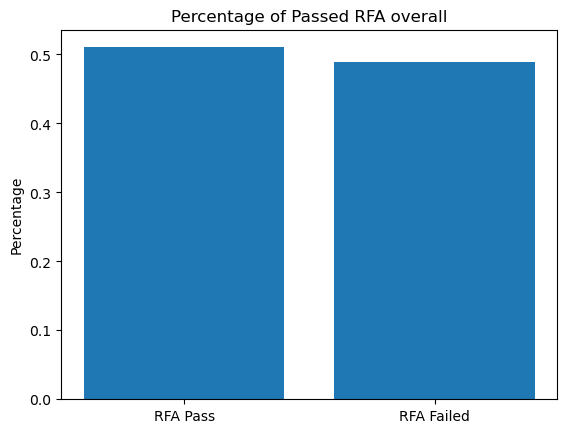

In [1553]:
plt.bar(['RFA Pass','RFA Failed'],unique_elections.RES.value_counts(normalize=True))
plt.ylabel('Percentage')
plt.title('Percentage of Passed RFA overall')

Redo Chart for attempts as a stacked bar chart with x axis (number of total attempts)

In [1554]:
import plotly.io as pio
import plotly.tools as tls

In [1555]:
fig, ax = plt.subplots()
bars = ax.bar(['RFA Pass','RFA Failed'],unique_elections.RES.value_counts(normalize=True))
plt.ylabel('Percentage')
plt.title('Percentage of Passed RFA overall')
fig = plt.gcf()
plotly_fig = tls.mpl_to_plotly(fig)
pio.write_html(plotly_fig, file='Plots/overall_pass_rate.html')

## Pass Rate by Year

In [1556]:
unique_elections.groupby(by='YEA')[['RES','YEA']].value_counts(normalize=False).unstack(fill_value=0)

RES,-1,1
YEA,,
2003,0,58
2004,58,236
2005,185,380
2006,472,347
2007,443,406
2008,332,201
2009,209,120
2010,141,75
2011,83,52


In [1557]:
unique_elections.groupby(by='YEA')[['RES','YEA']].value_counts(normalize=True).unstack(fill_value=0)

RES,-1,1
YEA,,
2003,0.000000,1.000000
2004,0.197279,0.802721
2005,0.327434,0.672566
2006,0.576313,0.423687
2007,0.521790,0.478210
2008,0.622889,0.377111
2009,0.635258,0.364742
2010,0.652778,0.347222
2011,0.614815,0.385185


Text(0.5, 1.0, 'Evolution of Pass Rates and votes')

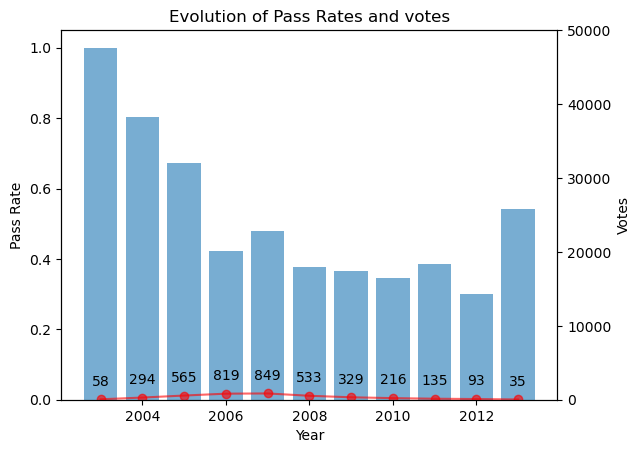

In [1558]:
fig, ax1 = plt.subplots()

ax1.bar(unique_elections.groupby(by='YEA')[['RES','YEA']].value_counts(normalize=False).unstack(fill_value=0).index, 
        unique_elections.groupby(by='YEA')[['RES','YEA']].value_counts(normalize=True).unstack(fill_value=0)[1], alpha=.6)

ax1.set_xlabel('Year')
ax1.set_ylabel('Pass Rate')

#TODO need to fix votes --> get from votes per election
ax2 = ax1.twinx()
ax2.plot(unique_elections.groupby(by='YEA')[['RES','YEA']].value_counts(normalize=False).unstack(fill_value=0).index, 
        unique_elections.groupby(by='YEA')[['RES','YEA']].value_counts(normalize=False).unstack(fill_value=0).agg('sum', axis=1), color ='red', alpha=.6, marker= 'o')

ax2.set_ylim((0,50000))
ax2.set_ylabel('Votes')

# Add values to the percentage line plot
for i, txt in enumerate(unique_elections.groupby(by='YEA')[['RES','YEA']].value_counts(normalize=False).unstack(fill_value=0).agg('sum', axis=1)):
    ax2.annotate(f"{txt:,}",  # Format the value to 2 decimal places
                 (unique_elections.groupby(by='YEA')[['RES','YEA']].value_counts(normalize=False).unstack(fill_value=0).agg('sum', axis=1).index[i], unique_elections.groupby(by='YEA')[['RES','YEA']].value_counts(normalize=False).unstack(fill_value=0).agg('sum', axis=1)[2003+i]),
                 textcoords="offset points",
                 xytext=(0, 10),  # Offset the text slightly above the point
                 ha='center', color='black')

plt.title('Evolution of Pass Rates and votes')

In [1559]:
fig, ax1 = plt.subplots()

ax1.bar(data.groupby(by='YEA')[['RES','YEA']].value_counts(normalize=False).unstack(fill_value=0).index, 
        data.groupby(by='YEA')[['RES','YEA']].value_counts(normalize=True).unstack(fill_value=0)[1], alpha=.6)

ax1.set_xlabel('Year')
ax1.set_ylabel('Pass Rate')


ax2 = ax1.twinx()
ax2.plot(data.groupby(by='YEA')[['RES','YEA']].value_counts(normalize=False).unstack(fill_value=0).index, 
        data.groupby(by='YEA')[['RES','YEA']].value_counts(normalize=False).unstack(fill_value=0).agg('sum', axis=1), color ='red', alpha=.6, marker= 'o')

ax2.set_ylim((0,50000))
ax2.set_ylabel('Votes')

# Add values to the percentage line plot
for i, txt in enumerate(data.groupby(by='YEA')[['RES','YEA']].value_counts(normalize=False).unstack(fill_value=0).agg('sum', axis=1)):
    ax2.annotate(f"{txt:,}",  # Format the value to 2 decimal places
                 (data.groupby(by='YEA')[['RES','YEA']].value_counts(normalize=False).unstack(fill_value=0).agg('sum', axis=1).index[i], data.groupby(by='YEA')[['RES','YEA']].value_counts(normalize=False).unstack(fill_value=0).agg('sum', axis=1)[2003+i]),
                 textcoords="offset points",
                 xytext=(0, 10),  # Offset the text slightly above the point
                 ha='center', color='black')

plt.title('Evolution of Pass Rates and votes')
fig = plt.gcf()
plotly_fig = tls.mpl_to_plotly(fig)
pio.write_html(plotly_fig, file='Plots/Evolution_of_Pass_Rates_and_votes.html')

c:\Users\mikai\anaconda3\Lib\site-packages\plotly\matplotlylib\renderer.py:645: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



Main Insights: 
- First year can be an anomaly since we don't have any negatives (may be an issue with the data) 
- 2004 onwards, pass rate is between 55% and 75% --> overall, chance of passing each year --> not really affected by growth in volume
- application volume increased till 2006; consistent decline since 2006 --> exponential growth and decline??? --> does wiki RFA have enough admins now?

Questions: 
- Does voter participation also increase over the years: total unique voters per year, elections voted per voter per year?
- should we drop 2003 year --> small sample and potentially tainted --> remove outliers

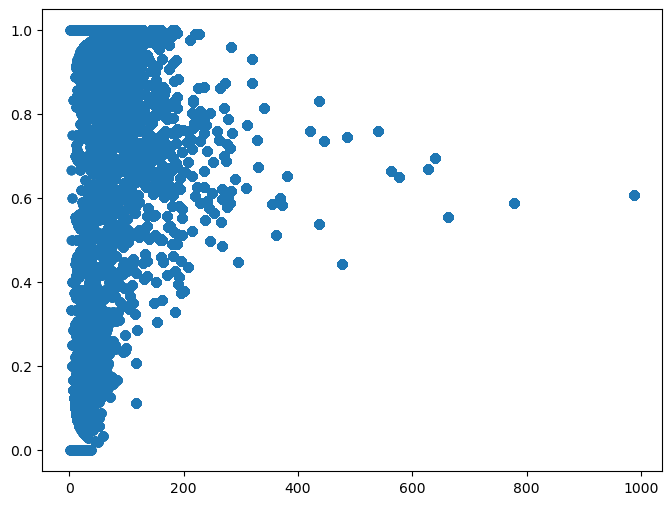

In [1560]:
plt.figure(figsize=(8,6))
plt.scatter(data_vote_polarity.votes, data_vote_polarity.pos_pct)

#Zoom in to focus on 0 to 200 (97.5% of data)
#plt.xlim((0,200))




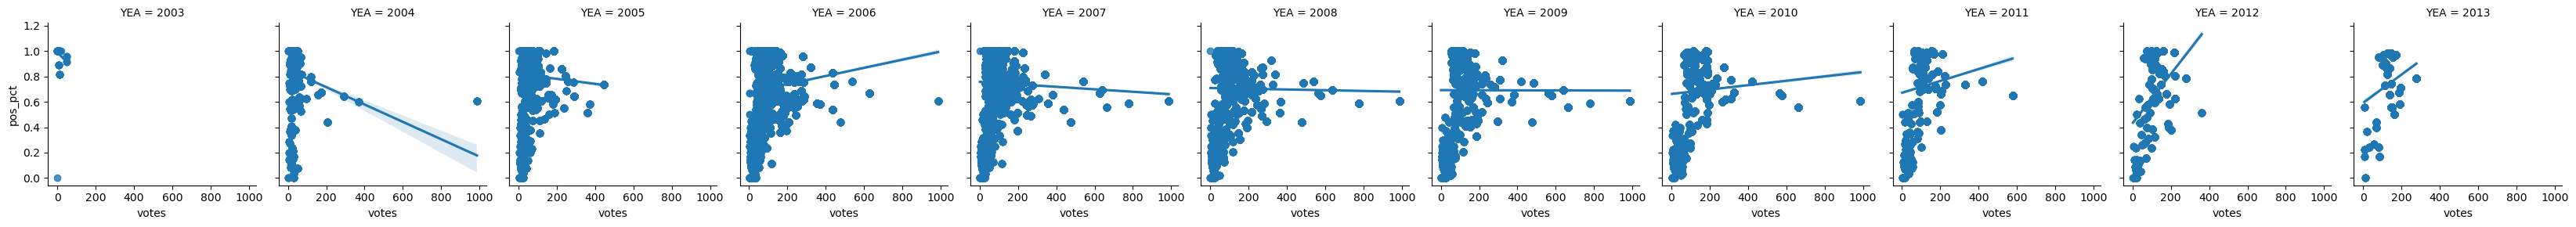

In [1561]:
sns.FacetGrid(data_vote_polarity, col='YEA').map(sns.regplot, 'votes','pos_pct')

Text(40.35487499999999, 0.5, 'Income per Capita [$]')

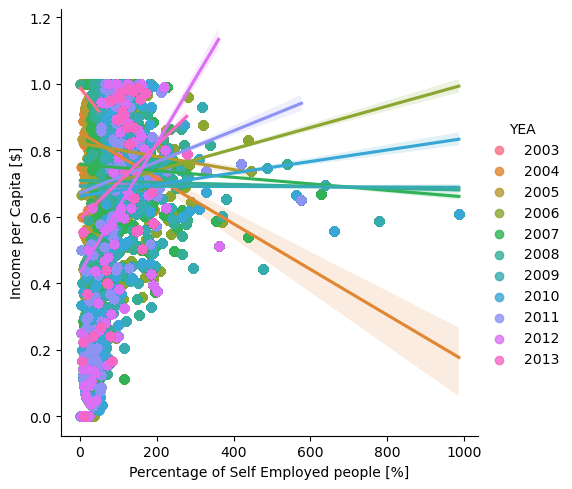

In [1562]:
sns.lmplot(x='votes',y='pos_pct', data=data_vote_polarity, hue = 'YEA')
plt.xlabel("Percentage of Self Employed people [%]")
plt.ylabel("Income per Capita [$]")
#plt.ylim([10000,60000])
#plt.xlim([0,25])

In [1563]:
plt.figure(figsize=(8,6))
plt.scatter(data_vote_polarity.votes, data_vote_polarity.pos_pct)

fig = plt.gcf()
plotly_fig = tls.mpl_to_plotly(fig)
pio.write_html(plotly_fig, file='Plots/vote_polarity.html')

Tried to see if there's any trend for participants and pass rates --> do we see higher pass rates for elections with more votes or opposite

next steps:
- remove 2003 data since it is only positive?
- plot by year (subplots), add slopes to compare trends (if any)
- try standardizing data

## Pass Rate by Candidate

In [1564]:
#How many candidates run only once (assuming candidates can only run once per year)
#Check if some elections happen across two years (i.e. Dec into Jan)
#Check if we have election id
#Numerator is for single year elections (proxy for one election candidates) from below
(702+681+489+410+274+240+152+100+79+55+28)/data_vote_polarity.groupby(['TGT'])['YEA'].unique().value_counts().sum()


0.9179296539891335

An overwhelming Majority of candidates only run once (92%) irrespective of outcome. 

In [1565]:
data_vote_polarity.groupby(['TGT'])['YEA'].unique().value_counts().sort_values(ascending=False).head(20)

YEA
[2007]          702
[2006]          681
[2005]          489
[2008]          410
[2004]          274
[2009]          240
[2010]          152
[2011]          100
[2012]           79
[2003]           55
[2013]           28
[2010, 2009]      1
[2006, 2005]      1
[2006, 2005]      1
[2008, 2007]      1
[2008, 2007]      1
[2006, 2005]      1
[2007, 2006]      1
[2006, 2005]      1
[2010, 2009]      1
Name: count, dtype: int64

Next steps: Election statistics by attempts --> pass rate, votes per election, ability to pass second time, margin of loss of the first loss 
Observation: Candidates run on consecutive years, after failing first time

# Vote Distribution by Election

In [1566]:
data_by_tgt = data.groupby(by='TGT').count().sort_values(by = 'SRC', ascending=False)
print(data_by_tgt.shape)
data_by_tgt.head(20)

(3497, 11)


,SRC,VOT,RES,YEA,DAT,MON,TIM,TXT,elec_id,total,votes
TGT,,,,,,,,,,,
Everyking,987,987,987,987,962,962,962,987,987,0,987
TenPoundHammer,778,778,778,778,764,764,764,778,778,0,778
MZMcBride,663,663,663,663,660,660,660,663,663,0,663
Cobi,639,639,639,639,635,635,635,639,639,0,639
Elonka,628,628,628,628,620,620,620,628,628,0,628
Ironholds,577,577,577,577,575,575,575,577,577,0,577
Kww,563,563,563,563,562,562,562,563,563,0,563
Werdna,540,540,540,540,527,527,527,540,540,0,540
Enigmaman,486,486,486,486,479,479,479,486,486,0,486


In [1567]:
#To check vote counts above a certain threshold
data_by_tgt[data_by_tgt['SRC']>200].SRC.count()

91

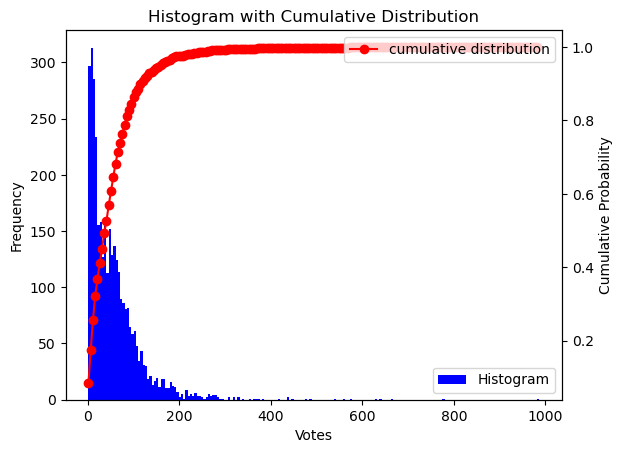

In [1568]:
fig, ax1 = plt.subplots()

counts, bins, patches = ax1.hist(data_by_tgt.SRC, bins= 200, cumulative = False, color= 'blue', label = 'Histogram')

#ax1 = plt.hist(x = data_by_tgt.SRC, bins=200, cumulative=False, label='Histogram')
ax1.set_xlabel('Votes')
ax1.set_ylabel('Frequency')
ax1.legend(loc= 'lower right')

cumulative = np.cumsum(counts)
cumulative = cumulative / cumulative[-1]

ax2 = ax1.twinx()

ax2.plot(bins[:-1], cumulative, color ='red', marker='o', label = 'cumulative distribution')

ax2.set_ylabel('Cumulative Probability')
ax2.legend(loc = 'upper right')

plt.title('Histogram with Cumulative Distribution') 
plt.show()

In [1569]:
election_mean = data_by_tgt.SRC.mean()
election_median = data_by_tgt.SRC.median()
election_mode = data_by_tgt.sort_values('SRC', ascending=True).SRC.quantile(q=0.5)
election_quant_9 = data_by_tgt.sort_values('SRC', ascending=True).SRC.quantile(q=0.9)

print('Mean: {:.0f} \nMedian: {:.0f} \nMode: {:.0f} \n90th percentile: {:.0f}'.format(election_mean, election_median, election_mode,election_quant_9 ))


Mean: 57 
Median: 41 
Mode: 41 
90th percentile: 120


In [1570]:
print('From above, we see that, on average, we have {:.1f} for an election.\
      \nHalf of our elections will have less than {:.0f} votes.\
      \nThe most frequent vote count for an election will be {:.0f} votes\
      \nWe can see that the 90% of the elections have less than {:.0f} votes.\
      '.format(election_mean, election_median, election_mode,election_quant_9))

From above, we see that, on average, we have 56.7 for an election.      
Half of our elections will have less than 41 votes.      
The most frequent vote count for an election will be 41 votes      
We can see that the 90% of the elections have less than 120 votes.      


# Comment Analysis 

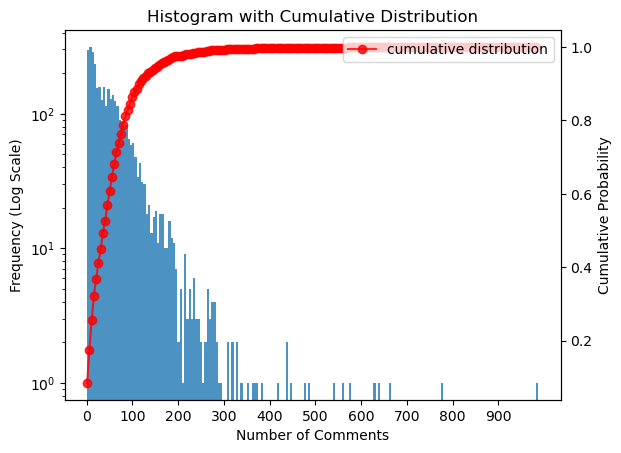

In [1571]:
fig, ax1 = plt.subplots()

counts, bins, patches = ax1.hist(data_vote_polarity.groupby('TGT')['TXT'].count(), bins= 200, cumulative = False, log = True, alpha = 0.8)

#ax1 = plt.hist(x = data_by_tgt.SRC, bins=200, cumulative=False, label='Histogram')
ax1.set_xlabel('Number of Comments')
ax1.set_ylabel('Frequency (Log Scale)')
plt.xticks(range(0,1000,100))
#ax1.legend(loc= 'lower right')

cumulative = np.cumsum(counts)
cumulative = cumulative / cumulative[-1]

ax2 = ax1.twinx()

ax2.plot(bins[:-1], cumulative, color ='red', alpha= 0.8, marker='o', label = 'cumulative distribution')

ax2.set_ylabel('Cumulative Probability')
ax2.legend(loc = 'upper right')

plt.title('Histogram with Cumulative Distribution') 
plt.show()

In the histogram, we can observe that the bulk of the mass located below 200, with a median around 50.

In [1572]:
print('90th Percentile: {:.0f}'.format(data_vote_polarity.groupby('TGT')['TXT'].count().quantile(0.9)))
print('95th Percentile: {:.0f}'.format(data_vote_polarity.groupby('TGT')['TXT'].count().quantile(0.95)))
print('99th Percentile: {:.0f}'.format(data_vote_polarity.groupby('TGT')['TXT'].count().quantile(0.99)))

print('\nBehavior of below the 95th percentile (inclusive):')
print(data_vote_polarity.groupby('TGT')['TXT'].count()[data_vote_polarity.groupby('TGT')['TXT'].count()<163+1].describe())

print('\nTail behavior beyond 99th percentile:')
print(data_vote_polarity.groupby('TGT')['TXT'].count()[data_vote_polarity.groupby('TGT')['TXT'].count()>276].describe())

90th Percentile: 120
95th Percentile: 163
99th Percentile: 276

Behavior of below the 95th percentile (inclusive):
count    3322.000000
mean       46.756171
std        37.801955
min         1.000000
25%        14.000000
50%        39.000000
75%        70.000000
max       163.000000
Name: TXT, dtype: float64

Tail behavior beyond 99th percentile:
count     35.000000
mean     420.542857
std      164.334906
min      277.000000
25%      302.000000
50%      361.000000
75%      481.000000
max      987.000000
Name: TXT, dtype: float64


Using the first table, we can see that we have a relatively low median of 39 comments with half our elections having between 14 and 70 comments according to the IQR. 
At the lower end of the range, semantic analysis may be less insightful as we might not have sufficient comments with meaningful sentiment. However, a further analysis of this subset should inspect whether the less comments reflects the candidates compentency, i.e. less to discuss about strong candidates.

In [1573]:
#Summ stats if we exclude 2003 bec
data_vote_polarity[~data_vote_polarity['YEA'].isin(['2003'])].groupby('TGT')['TXT'].count()[data_vote_polarity.groupby('TGT')['TXT'].count()<163+1].describe()

#not much difference in IQR --> not from lack of data in 2003

count    3322.000000
mean       46.756171
std        37.801955
min         1.000000
25%        14.000000
50%        39.000000
75%        70.000000
max       163.000000
Name: TXT, dtype: float64

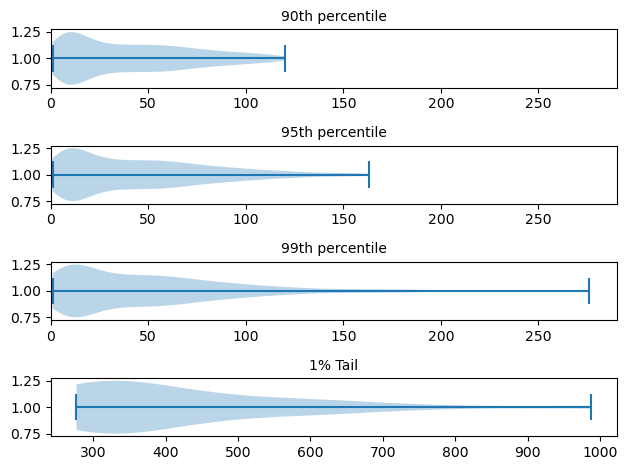

In [1574]:
fig, axs = plt.subplots(4,1)

axs[0].violinplot(data_vote_polarity.groupby('TGT')['TXT'].count()[data_vote_polarity.groupby('TGT')['TXT'].count()<120+1], vert = False)
axs[0].set_title('90th percentile', fontsize=10)
axs[0].set_xlim([0,290])

axs[1].violinplot(data_vote_polarity.groupby('TGT')['TXT'].count()[data_vote_polarity.groupby('TGT')['TXT'].count()<163+1], vert = False)
axs[1].set_title('95th percentile', fontsize=10)
axs[1].set_xlim([0,290])

axs[2].violinplot(data_vote_polarity.groupby('TGT')['TXT'].count()[data_vote_polarity.groupby('TGT')['TXT'].count()<276+1], vert = False)
axs[2].set_title('99th percentile', fontsize=10)
axs[2].set_xlim([0,290])

axs[3].violinplot(data_vote_polarity.groupby('TGT')['TXT'].count()[data_vote_polarity.groupby('TGT')['TXT'].count()>276], vert = False)
axs[3].set_title('1% Tail', fontsize=10)

plt.tight_layout()

We can see that distribution is positively skewed with 95% of the mass between 0 and 163 comments per election. There's a 

## by Year

In [1575]:
vote_count = data.drop_duplicates(subset = ['TGT','YEA'], keep='first',ignore_index=True)


In [1576]:
#describes vote per election
vote_count.groupby('YEA')['votes'].describe()

,count,mean,std,min,25%,50%,75%,max
YEA,,,,,,,,
2003,58.0,5.379310,8.851261,1.0,1.00,3.0,5.75,49.0
2004,289.0,29.871972,65.873412,2.0,14.00,19.0,28.00,987.0
2005,543.0,45.965009,46.712087,1.0,22.00,33.0,54.00,445.0
2006,790.0,68.905063,75.056800,1.0,21.00,56.0,84.00,987.0
2007,820.0,63.835366,80.906938,1.0,16.00,48.0,76.00,987.0
2008,521.0,77.527831,98.078813,1.0,12.00,57.0,100.00,987.0
2009,319.0,93.122257,116.935722,1.0,12.00,74.0,118.50,987.0
2010,212.0,93.476415,114.102409,3.0,15.00,71.0,119.50,987.0
2011,134.0,80.544776,81.125042,1.0,16.25,77.5,106.75,577.0


In [1577]:
data

,SRC,TGT,VOT,RES,YEA,DAT,MON,TIM,TXT,elec_id,total,votes
0,Steel1943,BDD,1,1,2013,2013-04-19,April,23:13:00,Support as conom.,301,NaN,137
1,Cuchullain,BDD,1,1,2013,2013-04-20,April,01:04:00,Support as nominator.,301,55.0,137
2,INeverCry,BDD,1,1,2013,2013-04-19,April,23:43:00,Support per noms.,301,6.0,137
3,Cncmaster,BDD,1,1,2013,2013-04-20,April,00:11:00,Support per noms. BDD is a strong contributor ...,301,6.0,137
4,Miniapolis,BDD,1,1,2013,2013-04-20,April,00:56:00,"Support, with great pleasure. I work with BDD ...",301,7.0,137
...,...,...,...,...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,2003-09-02,September,02:51:00,Support,3558,NaN,3
198271,Angela,WhisperToMe,1,1,2003,2003-11-26,November,23:45:00,Support.,3655,NaN,3
198272,Jiang,WhisperToMe,1,1,2003,NaN,NaN,NaN,Support.,3655,NaN,3
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05,December,05:38:00,Support. Age has nothing to do with maturity.,3655,NaN,3


In [1578]:
user_elec_particip = data.drop_duplicates(subset=['SRC','TGT','YEA','VOT']).groupby('SRC')['SRC'].value_counts().sort_values(ascending=False)
user_elec_particip.head()

SRC
Siva1979         1174
                 1100
Mailer diablo     975
Merovingian       883
Wizardman         779
Name: count, dtype: int64

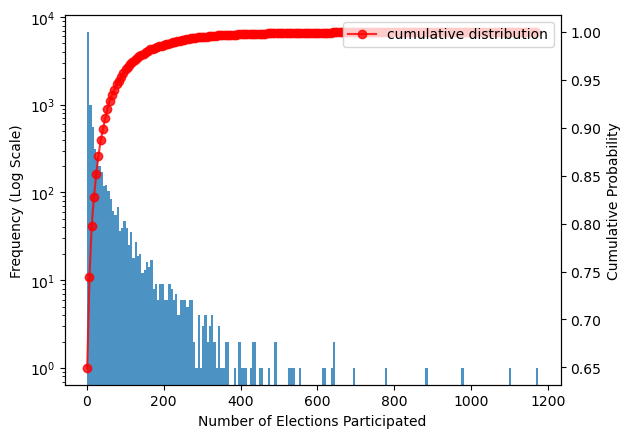

In [1579]:
fig, ax1 = plt.subplots()

counts, bins, patches = ax1.hist(user_elec_particip,
                                 bins= 200, cumulative = False, log = True, alpha = 0.8)

#ax1 = plt.hist(x = data_by_tgt.SRC, bins=200, cumulative=False, label='Histogram')
ax1.set_xlabel('Number of Elections Participated')
ax1.set_ylabel('Frequency (Log Scale)')
#plt.xticks(range(0,1000,100))
#ax1.legend(loc= 'lower right')

cumulative = np.cumsum(counts)
cumulative = cumulative / cumulative[-1]

ax2 = ax1.twinx()

ax2.plot(bins[:-1], cumulative, color ='red', alpha= 0.8, marker='o', label = 'cumulative distribution')

ax2.set_ylabel('Cumulative Probability')
ax2.legend(loc = 'upper right')

In [1580]:
print('90th percentile: {:.0f}'.format(user_elec_particip.quantile(0.90)))
print('90th percentile: {:.0f}'.format(user_elec_particip.quantile(0.95)))
print('90th percentile: {:.0f}'.format(user_elec_particip.quantile(0.99)))

90th percentile: 48
90th percentile: 90
90th percentile: 238


## Votes per Election + Comments + Unique Voters

In [1581]:
data_vote_polarity

,SRC,TGT,VOT,RES,YEA,DAT,MON,TIM,TXT,elec_id,total,votes,neg,neu,pos,neg_pct,neu_pct,pos_pct
0,Steel1943,BDD,1,1,2013,2013-04-19,April,23:13:00,Support as conom.,301,NaN,137,14,4,119,0.10219,0.029197,0.868613
1,Cuchullain,BDD,1,1,2013,2013-04-20,April,01:04:00,Support as nominator.,301,55.0,137,14,4,119,0.10219,0.029197,0.868613
2,INeverCry,BDD,1,1,2013,2013-04-19,April,23:43:00,Support per noms.,301,6.0,137,14,4,119,0.10219,0.029197,0.868613
3,Cncmaster,BDD,1,1,2013,2013-04-20,April,00:11:00,Support per noms. BDD is a strong contributor ...,301,6.0,137,14,4,119,0.10219,0.029197,0.868613
4,Miniapolis,BDD,1,1,2013,2013-04-20,April,00:56:00,"Support, with great pleasure. I work with BDD ...",301,7.0,137,14,4,119,0.10219,0.029197,0.868613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,2003-09-02,September,02:51:00,Support,3558,NaN,3,0,0,3,0.00000,0.000000,1.000000
198271,Angela,WhisperToMe,1,1,2003,2003-11-26,November,23:45:00,Support.,3655,NaN,3,0,0,3,0.00000,0.000000,1.000000
198272,Jiang,WhisperToMe,1,1,2003,NaN,NaN,NaN,Support.,3655,NaN,3,0,0,3,0.00000,0.000000,1.000000
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05,December,05:38:00,Support. Age has nothing to do with maturity.,3655,NaN,3,0,0,3,0.00000,0.000000,1.000000


# Notes 

## Notes on Dataset

- An election starting in Decemeber will continue in the following year --> Problems: 
    - election statistics by year are double-counting --> use start or final date to account --> Standardize dates to datetime?
- Voters can change votes --> need to adjust pass rates to only account for final voting intention
    - For prediction: How many votes change per election, and are they clustered (could be related to discussion) or random
- how many rejected people come run again?
- Persistence of Negative votes --> what percentage of negative voters in first rejection continue to vote in 2nd election (if exists)
    - how many switch voting camps from negative to positive
- Persistence of positive votes --> what percentage of positive voters in first rejection continue to vote in 2nd election 
    - how many switch voting camps from positive to negative

section title if vote only correlate with own comments --> Grudge Match